## Домашнее задание №9
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [2]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [3]:
# do not change the code in the block below
# __________start of block__________
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("{} device is available".format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [4]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-18 21:11:58--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.006s  

2024-11-18 21:11:58 (43.2 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [5]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ["<sos>"]
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [6]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx["<sos>"]


def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size * seq_length - 1)
    data = np.array(
        text_encoded[start_index : start_index + batch_size * seq_length]
    ).reshape((batch_size, -1))
    yield np.hstack((start_column, data))


# __________end of block__________

Пример батча:

In [7]:
next(generate_chunk())

array([[83,  1, 62, ..., 52, 50, 54],
       [83,  1, 61, ..., 70, 50,  1],
       [83, 58, 50, ..., 59, 54,  1],
       ...,
       [83, 47, 61, ..., 43, 58, 64],
       [83,  5,  1, ..., 47, 59, 63],
       [83,  1, 46, ...,  0, 53,  1]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [64]:
class LSTM(nn.Module):
  def __init__(self, n_vocab, hidden_dim, embedding_dim, dropout=0.25):
        super(LSTM, self).__init__()
        self.hidden_dim, self.embedding_dim = hidden_dim, embedding_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout, num_layers=3)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)
  def forward(self, seq_in, hidden):
        embedded = self.embeddings(seq_in)
        output, hidden = self.lstm(embedded)
        ht = output[:, -1]
        out = self.fc(output)
        return out, hidden


В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

In [22]:
for batch in range(len(text_encoded) // (batch_size * seq_length)):
            # Генерация данных
  data = next(generate_chunk())  # (256, seq_length + 1)

            # Уменьшаем данные до batch_size:
  data = data[:batch_size, :]  # Берём только первые batch_size строк (128 строк)
  # print(data.shape)
  inputs = torch.tensor(data[:, :-1], dtype=torch.long).to(device)  # Входы
  targets = torch.tensor(data[:, 1:], dtype=torch.long).to(device)  # Цели
  print(targets.shape)

torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])


In [46]:
def train(net, criterion, optimizer, num_epochs=10, device="cpu"):
    net.to(device)
    history = []

    for epoch in range(num_epochs):
        net.train()
        total_loss = 0

        for batch in range(len(text_encoded) // (batch_size * seq_length)):
            # Генерация данных
            data = next(generate_chunk())  # (batch_size, seq_length + 1)

            inputs = torch.tensor(data[:, :-1], dtype=torch.long).to(device)  # Входы
            targets = torch.tensor(data[:, 1:], dtype=torch.long).to(device)  # Цели

            optimizer.zero_grad()

            # Выходы модели: (batch_size, seq_length, vocab_size)
            outputs = net(inputs, None)

            # Преобразуем размеры для CrossEntropyLoss
            outputs = outputs.view(-1, outputs.size(-1))  # (batch_size * seq_length, vocab_size)
            targets = targets.view(-1)  # (batch_size * seq_length)

            # Проверка на корректность размеров
            if outputs.size(0) != targets.size(0):
                print(f"Mismatch in shapes: outputs={outputs.shape}, targets={targets.shape}")
                raise ValueError("Shapes of outputs and targets do not match!")

            # Вычисление лосса
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Средний лосс за эпоху
        average_loss = total_loss / (len(text_encoded) // (batch_size * seq_length))
        history.append(average_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")

    return net, history


# Определение параметров модели
hidden_dim = 128  # размер скрытого слоя
embedding_dim = 64  # размер эмбеддингов
dropout = 0.25  # вероятность дропаут слоя

# Создание и перенос модели на устройство
net = LSTM(n_vocab=num_tokens, hidden_dim=hidden_dim, embedding_dim=embedding_dim, dropout=dropout)
net = net.to(device)

# Определение функции потерь и оптимизатора
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Запуск обучения
net, history = train(
    net, criterion, optimizer,
    num_epochs=40,
)


Epoch 1/40, Loss: 4.3987
Epoch 2/40, Loss: 4.1585
Epoch 3/40, Loss: 3.5984
Epoch 4/40, Loss: 3.4158
Epoch 5/40, Loss: 3.3641
Epoch 6/40, Loss: 3.3401
Epoch 7/40, Loss: 3.3276
Epoch 8/40, Loss: 3.3225
Epoch 9/40, Loss: 3.3183
Epoch 10/40, Loss: 3.3197
Epoch 11/40, Loss: 3.3114
Epoch 12/40, Loss: 3.3123
Epoch 13/40, Loss: 3.3148
Epoch 14/40, Loss: 3.3105
Epoch 15/40, Loss: 3.3083
Epoch 16/40, Loss: 3.3127
Epoch 17/40, Loss: 3.3099
Epoch 18/40, Loss: 3.3064
Epoch 19/40, Loss: 3.3125
Epoch 20/40, Loss: 3.3101
Epoch 21/40, Loss: 3.3107
Epoch 22/40, Loss: 3.3109
Epoch 23/40, Loss: 3.3007
Epoch 24/40, Loss: 3.3053
Epoch 25/40, Loss: 3.3013
Epoch 26/40, Loss: 3.3081
Epoch 27/40, Loss: 3.3057
Epoch 28/40, Loss: 3.3122
Epoch 29/40, Loss: 3.3077
Epoch 30/40, Loss: 3.3055
Epoch 31/40, Loss: 3.3012
Epoch 32/40, Loss: 3.3073
Epoch 33/40, Loss: 3.3064
Epoch 34/40, Loss: 3.3136
Epoch 35/40, Loss: 3.3034
Epoch 36/40, Loss: 3.2916
Epoch 37/40, Loss: 3.2949
Epoch 38/40, Loss: 3.2727
Epoch 39/40, Loss: 3.

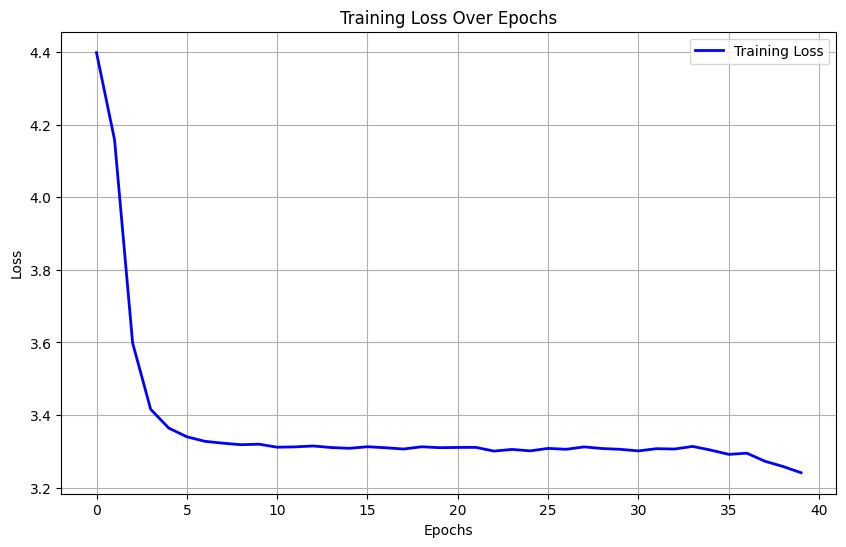

In [47]:

def plot_loss(history):
    # Создание графика
    plt.figure(figsize=(10, 6))
    plt.plot(history, label='Training Loss', color='b', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Вызываем функцию для построения графика
plot_loss(history)

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [48]:
def generate_sample(
    char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device
):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    if seed_phrase is not None:
        x_sequence = [token_to_idx["<sos>"]] + [
            token_to_idx[token] for token in seed_phrase
        ]
    else:
        x_sequence = [token_to_idx["<sos>"]]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # feed the seed phrase, if any

    # your code here

    return "".join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [65]:
net = net.to(device)  # Переносим модель на нужное устройство

def generate_sample(
    char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device
):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    # Преобразование seed_phrase в индексы
    if seed_phrase is not None:
        x_sequence = [token_to_idx["<sos>"]] + [
            token_to_idx[token] for token in seed_phrase
        ]
    else:
        x_sequence = [token_to_idx["<sos>"]]

    # Преобразуем x_sequence в тензор и отправляем на устройство
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # Начальная инициализация скрытых состояний модели
    hidden = None  # Для LSTM/GRU скрытое состояние должно быть инициализировано (если необходимо)

    generated_text = seed_phrase if seed_phrase else ""

    # Генерация текста
    for _ in range(max_length - len(x_sequence[0])):
        output, hidden = char_rnn(x_sequence, hidden)  # Получаем выход модели
        output = output[:, -1, :]  # Получаем только последний прогноз для текущего шага

        # Применяем temperature для более случайного выбора
        output = output / temperature  # Уменьшаем/увеличиваем отклонения

        # Применяем softmax, чтобы получить вероятности для всех символов
        probabilities = torch.softmax(output, dim=-1)

        # Выбираем символ с вероятностью
        next_token_idx = torch.multinomial(probabilities, 1).item()

        # Добавляем символ в последовательность
        x_sequence = torch.cat([x_sequence, torch.tensor([[next_token_idx]], dtype=torch.int64).to(device)], dim=1)

        # Конвертируем индекс в символ и добавляем его в результат
        generated_text += tokens[next_token_idx]

        # Если сгенерированный символ — это <eos>, то завершаем генерацию
        if tokens[next_token_idx] == "<eos>":
            break

    return generated_text


Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [66]:
generated_text = generate_sample(
    net, "мой дядя самых честных правил", max_length=500, temperature=0.8, device=device
)
print(generated_text)


ValueError: not enough values to unpack (expected 2, got 1)

### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = " мой дядя самых честных правил"

In [ ]:
generated_phrases = # your code here

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [ ]:
output = {key: ','.join([str(x) for x in list(data.item()[key])]) for key in 'train', 'test'}

In [ ]:
# do not change the code in the block below
# __________start of block__________

if "generated_phrases" not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all(
        [x in set(tokens) for x in set(list(phrase))]
    ), "Unknown tokens detected, check your submission!"


submission_dict = {"token_to_idx": token_to_idx, "generated_phrases": generated_phrases}

np.save("submission_dict_hw09.npy", submission_dict, allow_pickle=True)
print("File saved to `submission_dict_hw09.npy`")
# __________end of block__________

На этом задание завершено. Поздравляем!